<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 4: рекомендательные системы</center></h2>
<h3><center>Выполнила Шеневская Влада</center></h3>

# Введение

В этом задании Вы продолжите работать с данными из семинара [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).

# Загрузка и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import math

Загрузим данные и проведем предобраотку данных как на семинаре.

In [2]:
!kaggle datasets download -d gspmoreira/articles-sharing-reading-from-cit-deskdrop
!unzip articles-sharing-reading-from-cit-deskdrop.zip -d articles

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open articles-sharing-reading-from-cit-deskdrop.zip, articles-sharing-reading-from-cit-deskdrop.zip.zip or articles-sharing-reading-from-cit-deskdrop.zip.ZIP.


In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [4]:
! unzip "/content/drive/MyDrive/Colab Notebooks/shared_articles.csv.zip"

Archive:  /content/drive/MyDrive/Colab Notebooks/shared_articles.csv.zip
  inflating: shared_articles.csv     


In [68]:
articles_df = pd.read_csv("shared_articles.csv")
articles_df = articles_df[articles_df["eventType"] == "CONTENT SHARED"] # оставляем только существующие статьи, уже удаленные убираем тк не можем по ним строить рекомендации
articles_df.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


In [69]:
articles_df.isna().sum() # есть пропуски

timestamp             0
eventType             0
contentId             0
authorPersonId        0
authorSessionId       0
authorUserAgent    2378
authorRegion       2378
authorCountry      2378
contentType           0
url                   0
title                 0
text                  0
lang                  0
dtype: int64

In [70]:
articles_df.replace({np.nan:0}, inplace=True) # убирем все NAN значения

In [71]:
articles_df.isna().sum()

timestamp          0
eventType          0
contentId          0
authorPersonId     0
authorSessionId    0
authorUserAgent    0
authorRegion       0
authorCountry      0
contentType        0
url                0
title              0
text               0
lang               0
dtype: int64

In [72]:
! unzip "/content/drive/MyDrive/Colab Notebooks/users_interactions.csv.zip"

Archive:  /content/drive/MyDrive/Colab Notebooks/users_interactions.csv.zip
replace users_interactions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [73]:
interactions_df = pd.read_csv("users_interactions.csv")
interactions_df.head(2) 
# в eventType указывается, какие действия совершал пользователь

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US


In [74]:
interactions_df.isna().sum() # есть пропуски

timestamp          0
eventType          0
contentId          0
personId           0
sessionId          0
userAgent      15394
userRegion     15405
userCountry    15394
dtype: int64

In [75]:
interactions_df.replace({np.nan:0}, inplace=True) # убирем все NAN значения

In [76]:
interactions_df.isna().sum() 

timestamp      0
eventType      0
contentId      0
personId       0
sessionId      0
userAgent      0
userRegion     0
userCountry    0
dtype: int64

In [77]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)
articles_df.contentId = articles_df.contentId.astype(str)

In [78]:
# зададим словарь определяющий силу взаимодействия 
# разные действия пользователей, а хотим работать с одной величиной, характеризующей все взаимодействие пользователя со статьей
event_type_strength = {
   "VIEW": 1.0,
   "LIKE": 2.0, 
   "BOOKMARK": 2.5, 
   "FOLLOW": 3.0,
   "COMMENT CREATED": 4.0,  
}

# создаем новую колонку
interactions_df["eventStrength"] = interactions_df.eventType.apply(lambda x: event_type_strength[x])
# считаем числовую величину "оценки" пользователем статьи с указанными выше весами

Оставляем только тех пользователей, которые произамодействовали более чем с пятью статьями тк рекомендательные системы часто подвержены проблеме холодного старта.

In [79]:
users_interactions_count_df = (
    interactions_df
    .groupby(["personId", "contentId"])
    .first()
    .reset_index()
    .groupby("personId").size())
print("# users:", len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[["personId"]]
print("# users with at least 5 interactions:",len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


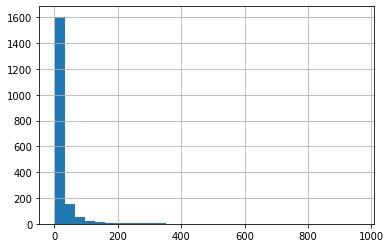

In [80]:
users_interactions_count_df.hist(bins=30);

Оставляем только те взаимодействия, которые относятся к отфильтрованным пользователям.

In [81]:
interactions_from_selected_users_df = interactions_df.loc[np.in1d(interactions_df.personId,
            users_with_enough_interactions_df)]

In [82]:
print(f"# interactions before: {interactions_df.shape}")
print(f"# interactions after: {interactions_from_selected_users_df.shape}")

# interactions before: (72312, 9)
# interactions after: (69868, 9)


Объединяем все взаимодействия пользователя по каждой статье (тк один и тот же пользователь в данной постановке мог взаимодейтсвовать с каждой статьей более 1 раза (совершая разные действия)) и сглаживаем полученный результат, взяв от него логарифм (тк полученное число будет тем больше, чем больше взаимодействий со статьей произвел человек).

In [83]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(["personId", "contentId"]).eventStrength.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(["personId", "contentId"])
)
interactions_full_df["last_timestamp"] = (
    interactions_from_selected_users_df
    .groupby(["personId", "contentId"])["timestamp"].last()
)
        
interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head(5)

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994324


Разобьём выборку на обучение и контроль по времени.

In [84]:
from sklearn.model_selection import train_test_split

split_ts = 1475519530
interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestamp < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestamp >= split_ts].copy()

print(f"# interactions on Train set: {len(interactions_train_df)}")
print(f"# interactions on Test set: {len(interactions_test_df)}")

interactions_train_df

# interactions on Train set: 29329
# interactions on Test set: 9777


,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.0,1470395911
2,-1007001694607905623,-793729620925729327,1.0,1472834892
6,-1032019229384696495,-1006791494035379303,1.0,1469129122
7,-1032019229384696495,-1039912738963181810,1.0,1459376415
8,-1032019229384696495,-1081723567492738167,2.0,1464054093
...,...,...,...,...
39099,997469202936578234,9112765177685685246,2.0,1472479493
39100,998688566268269815,-1255189867397298842,1.0,1474567164
39101,998688566268269815,-401664538366009049,1.0,1474567449
39103,998688566268269815,6881796783400625893,1.0,1474567675


Для удобства подсчёта качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков.

In [85]:
interactions = (
    interactions_train_df
    .groupby("personId")["contentId"].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={"contentId": "true_train"})
    .set_index("personId")
)

interactions["true_test"] = (
    interactions_test_df
    .groupby("personId")["contentId"].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), "true_test"] = [
    "" for x in range(len(interactions.loc[pd.isnull(interactions.true_test), "true_test"]))]

interactions.head(1)

,true_train,true_test
personId,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72..."


# Библиотека LightFM

Для рекомендации Вы будете пользоваться библиотекой [LightFM](https://making.lyst.com/lightfm/docs/home.html), в которой реализованы популярные алгоритмы. Для оценивания качества рекомендации, как и на семинаре, будем пользоваться метрикой *precision@10*.

In [ ]:
!pip install lightfm

In [29]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

## Задание 1 (2 балла)

Модели в LightFM работают с разреженными матрицами. Создайте разреженные матрицы `data_train` и `data_test` (размером количество пользователей на количество статей), такие что на пересечении строки пользователя и столбца статьи стоит сила их взаимодействия, если взаимодействие было, и стоит ноль, если взаимодействия не было.

Использовала этот ресурс при решении этого пункта: https://python.plainenglish.io/introduction-to-recommender-systems-using-lightfm-in-azure-ml-e86feaff6ac4


In [35]:
from scipy.sparse import csr_matrix

In [66]:
from lightfm.data import Dataset
dataset1 = Dataset()

In [89]:
dataset1.fit(interactions_full_df["personId"].unique(),
             interactions_full_df["contentId"].unique())

(train_matrix, train_matrix_weights) = dataset1.build_interactions([(x[0], x[1]) for x in interactions_train_df.values])
(test_matrix, test_matrix_weights) = dataset1.build_interactions([(x[0], x[1]) for x in interactions_test_df.values])

## Задание 2 (1 балл)

Обучите модель LightFM с `loss="warp"` и посчитайте *precision@10* на тесте.

In [97]:
model = LightFM(loss='warp', random_state=111)
model.fit(interactions=train_matrix, sample_weight=train_matrix_weights, epochs=30)

In [98]:
print(f"Train precision@10: {precision_at_k(model,k=10,test_interactions=train_matrix).mean()}")
print(f"Test precision@10: {precision_at_k(model,k=10,test_interactions=test_matrix).mean()}")

Train precision@10: 0.2465827465057373
Test precision@10: 0.004684318322688341


## Задание 3 (3 балла)

При вызове метода `fit` LightFM позволяет передавать в `item_features` признаковое описание объектов. Воспользуемся этим. Будем получать признаковое описание из текста статьи в виде [TF-IDF](https://ru.wikipedia.org/wiki/TF-IDF) (можно воспользоваться `TfidfVectorizer` из scikit-learn). Создайте матрицу `feat` размером количесвто статей на размер признакового описание и обучите LightFM с `loss="warp"` и посчитайте precision@10 на тесте.

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [100]:
vector = TfidfVectorizer()
feat = vector.fit_transform(articles_df['text'])

In [106]:
model2 = LightFM(loss='warp', random_state=111)
model2.fit(interactions=train_matrix, sample_weight=train_matrix_weights, item_features=feat, epochs=30)

In [108]:
print(f"Train precision@10: {precision_at_k(model2, k=10, test_interactions=train_matrix, item_features=feat).mean()}")

Train precision@10: 0.23660075664520264


In [107]:
print(f"Test precision@10: {precision_at_k(model2,k=10,test_interactions=test_matrix, item_features=feat).mean()}")

Test precision@10: 0.00529531529173255


## Задание 4 (2 балла)

В задании 3 мы использовали сырой текст статей. В этом задании необходимо сначала сделать предобработку текста (привести к нижнему регистру, убрать стоп слова, привести слова к номральной форме и т.д.), после чего обучите модель и оценить качество на тестовых данных.

Использовала эту тетрадку: https://github.com/hse-ds/iad-intro-ds/blob/master/2021/seminars/sem10_texts.ipynb 

In [109]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [123]:
import nltk
nltk.download("stopwords")
from string import punctuation
from nltk.stem.snowball import SnowballStemmer
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Взяла функцию из своего ДЗ6 по введению в анализ данных

In [124]:
def Customtokenizer(s):
    s = s.lower()
    h = word_tokenize(s)
    deli_lst = stopwords.words('english')
    d = []
    stemmer = SnowballStemmer('english')
    for i in h:
        if (i not in deli_lst) and (re.findall(r'[0-9]+', i) == []) and \
        (re.findall(r'[!"\$%&\'()*+,\-.\—/:;=#@?\\\\^_`«»{|}~]+', i) == []) and \
        (']' not in i) and \
        ('[' not in i): 
            j = stemmer.stem(i)
            d.append(j)
    return d 

In [125]:
vector2 = TfidfVectorizer(analyzer='word', tokenizer=Customtokenizer)
feat2 = vector2.fit_transform(articles_df['text'])

In [126]:
model3 = LightFM(loss='warp', random_state=111)
model3.fit(interactions=train_matrix, sample_weight=train_matrix_weights, item_features=feat2, epochs=30)

In [127]:
print(f"Train precision@10: {precision_at_k(model3, k=10, test_interactions=train_matrix, item_features=feat2).mean()}")
print(f"Test precision@10: {precision_at_k(model3,k=10,test_interactions=test_matrix, item_features=feat2).mean()}")

Train precision@10: 0.23255395889282227
Test precision@10: 0.0047861505299806595


Улучшилось ли качество предсказания?

Незначительно, вообще даже немного упало


## Задание 5 (2 балла)

Подберите гиперпараметры модели LightFM (`n_components` и др.) для улучшения качества модели.

max_sampled – максимальное количество отрицательных комбинаций при WARP fitting, увеличивая число, можно улучшить точность

learning_schedule выбрали 'adagrad'

learning_rate для adagrad learning schedule

In [130]:
model4 = LightFM(loss='warp', learning_schedule='adagrad', max_sampled=20, random_state=111)
model4.fit(interactions=train_matrix, sample_weight=train_matrix_weights, item_features=feat, epochs=30)

In [131]:
print(f"Train precision@10: {precision_at_k(model4, k=10, test_interactions=train_matrix, item_features=feat).mean()}")
print(f"Test precision@10: {precision_at_k(model4,k=10,test_interactions=test_matrix, item_features=feat).mean()}")

Train precision@10: 0.2632194459438324
Test precision@10: 0.004073319956660271


In [132]:
model4 = LightFM(loss='warp', learning_schedule='adagrad', max_sampled=30, random_state=111)
model4.fit(interactions=train_matrix, sample_weight=train_matrix_weights, item_features=feat, epochs=30)

In [133]:
print(f"Train precision@10: {precision_at_k(model4, k=10, test_interactions=train_matrix, item_features=feat).mean()}")
print(f"Test precision@10: {precision_at_k(model4,k=10,test_interactions=test_matrix, item_features=feat).mean()}")

Train precision@10: 0.2751798629760742
Test precision@10: 0.004073319956660271


In [134]:
model4 = LightFM(loss='warp', learning_schedule='adagrad', max_sampled=30, learning_rate=0.1, random_state=111)
model4.fit(interactions=train_matrix, sample_weight=train_matrix_weights, item_features=feat, epochs=30)

In [135]:
print(f"Train precision@10: {precision_at_k(model4, k=10, test_interactions=train_matrix, item_features=feat).mean()}")
print(f"Test precision@10: {precision_at_k(model4,k=10,test_interactions=test_matrix, item_features=feat).mean()}")

Train precision@10: 0.2829137146472931
Test precision@10: 0.003971486818045378


Качество на тесте падает, тогда как на тренировочной выборке растет, подбираем дальше

In [136]:
model4 = LightFM(loss='warp', learning_schedule='adagrad', max_sampled=30, learning_rate=0.1, random_state=111)
model4.fit(interactions=train_matrix, sample_weight=train_matrix_weights, item_features=feat, epochs=50)

In [137]:
print(f"Train precision@10: {precision_at_k(model4, k=10, test_interactions=train_matrix, item_features=feat).mean()}")
print(f"Test precision@10: {precision_at_k(model4,k=10,test_interactions=test_matrix, item_features=feat).mean()}")

Train precision@10: 0.2918165326118469
Test precision@10: 0.004073319956660271


In [138]:
model4 = LightFM(loss='warp', learning_schedule='adagrad', max_sampled=30, learning_rate=0.1, no_components=30, random_state=111)
model4.fit(interactions=train_matrix, sample_weight=train_matrix_weights, item_features=feat, epochs=50)

In [139]:
print(f"Train precision@10: {precision_at_k(model4, k=10, test_interactions=train_matrix, item_features=feat).mean()}")
print(f"Test precision@10: {precision_at_k(model4,k=10,test_interactions=test_matrix, item_features=feat).mean()}")

Train precision@10: 0.5876798629760742
Test precision@10: 0.0023421586956828833


In [141]:
model5 = LightFM(loss='warp', learning_schedule='adagrad', max_sampled=30, no_components=30, random_state=111)
model5.fit(interactions=train_matrix, sample_weight=train_matrix_weights, item_features=feat, epochs=50)

In [142]:
print(f"Train precision@10: {precision_at_k(model5, k=10, test_interactions=train_matrix, item_features=feat).mean()}")
print(f"Test precision@10: {precision_at_k(model5,k=10,test_interactions=test_matrix, item_features=feat).mean()}")

Train precision@10: 0.542715847492218
Test precision@10: 0.0016293278895318508


In [147]:
model6 = LightFM(learning_rate=0.03, loss='warp', no_components=40)
model6.fit(interactions=train_matrix, sample_weight=train_matrix_weights, item_features=feat, epochs=50)

In [148]:
print(f"Train precision@10: {precision_at_k(model6, k=10, test_interactions=train_matrix, item_features=feat).mean()}")
print(f"Test precision@10: {precision_at_k(model6,k=10,test_interactions=test_matrix, item_features=feat).mean()}")

Train precision@10: 0.46915462613105774
Test precision@10: 0.003564154962077737


## Бонусное задание (3 балла)

Выше мы использовали достаточно простое представление текста статьи в виде TF-IDF. В этом задании Вам нужно представить текст статьи (можно вместе с заголовком) в виде эмбеддинга полученного с помощью рекуррентной сети или трансформера (можно использовать любую предобученную модель, которая Вам нравится). Обучите модель с ипользованием этих эмеддингов и сравните результаты с предыдущими.

In [ ]:
# Ваш код здесь